<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/v5_apptom_early%20stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [6]:
!kaggle datasets download -d manjuphoenix/tomatodataset 
!kaggle datasets download -d manjuphoenix/appledataset

 97% 898M/923M [00:04<00:00, 191MB/s]
100% 923M/923M [00:04<00:00, 196MB/s]
 95% 315M/333M [00:02<00:00, 160MB/s]
100% 333M/333M [00:02<00:00, 164MB/s]


In [7]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [8]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [9]:
!sudo mkdir /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset
!sudo cp -rf /content/Apple/* /content/dataset

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.8)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])


# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a validation set is: 27392
The number of images in a test set is: 5504
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [22]:
from PIL import Image
from pathlib import Path
from torch.autograd import Variable

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 100)
        self.fc2 = nn.Linear(100, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()

model = model.to(device)
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v4_tomato.pk1'))
model.load_state_dict(checkpoint)
model = model.to(device)

In [23]:
# !pip install torch-summary
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
         LeakyReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 130, 130]           4,640
         LeakyReLU-5         [-1, 32, 130, 130]               0
         MaxPool2d-6           [-1, 32, 65, 65]               0
            Linear-7                  [-1, 100]      13,520,100
            Linear-8                    [-1, 8]             808
Total params: 13,526,764
Trainable params: 13,526,764
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 27.28
Params size (MB): 51.60
Estimated Total Size (MB): 79.63
----------------------------------------------------------------


In [24]:
# model.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
model.fc2 = nn.Linear(100, 12)

In [25]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=12, bias=True)
)

In [26]:


class EarlyStopping():
  """ Early stopping is used to stop the training process to avoid overfitting of the model when the loss does not improve after certain epochs"""
  def __init__(self, patience=6, min_delta=0):
      """
      Parameters:
      Patience: Number of epochs to wait before stopping when the loss is not improving
      min_delta: Minimum difference between new loss and the old loss for new loss to be considered as an improvement
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.best_loss = None
      self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print("INFO: Early Stopping")
        self.early_stop = True

In [27]:
from tqdm import tqdm

def train(model,loss_fn,dataloader,optimizer,epoch):
    print('\nEpoch : %d'%epoch)
    total_loss=0    
    correct=0
    total=0

    model.train()
    for data in tqdm(dataloader):
        inputs,labels=data[0].to(device),data[1].to(device)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    loss=total_loss/len(dataloader)
    accuracy=100.*correct/total
    
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.4f | Accuracy: %.4f'%(loss,accuracy))
    return loss, accuracy

In [28]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()
    total_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= loss_fn(outputs,labels)
            total_loss+=loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        loss=total_loss/len(dataloader)
        accuracy=100.*correct/total
        losses['val'].append(loss)
        accuracies['val'].append(accuracy)
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 
    return loss, accuracy

In [29]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [30]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=300
early_stopping = EarlyStopping()
for epoch in range(1,epochs+1): 
  train_loss, train_accuracy = train(model,loss_fn,train_loader,optimizer_ft,epoch)
  val_loss, val_accuracy = test(model,loss_fn,val_loader,epoch)
  early_stopping(val_loss)
  if early_stopping.early_stop:
    break


Epoch : 1


100%|██████████| 3993/3993 [05:56<00:00, 11.19it/s]


Train Loss: 1.3008 | Accuracy: 58.0472


100%|██████████| 856/856 [01:12<00:00, 11.74it/s]


Test Loss: 0.982 | Accuracy: 68.229

Epoch : 2


100%|██████████| 3993/3993 [05:53<00:00, 11.29it/s]


Train Loss: 0.9074 | Accuracy: 69.8774


100%|██████████| 856/856 [01:12<00:00, 11.75it/s]


Test Loss: 0.863 | Accuracy: 70.486

Epoch : 3


100%|██████████| 3993/3993 [05:55<00:00, 11.22it/s]


Train Loss: 0.8114 | Accuracy: 73.0459


100%|██████████| 856/856 [01:13<00:00, 11.69it/s]


Test Loss: 0.785 | Accuracy: 73.942

Epoch : 4


100%|██████████| 3993/3993 [05:56<00:00, 11.20it/s]


Train Loss: 0.7515 | Accuracy: 75.1906


100%|██████████| 856/856 [01:13<00:00, 11.61it/s]


Test Loss: 0.748 | Accuracy: 75.063

Epoch : 5


100%|██████████| 3993/3993 [05:55<00:00, 11.22it/s]


Train Loss: 0.7171 | Accuracy: 76.2989


100%|██████████| 856/856 [01:13<00:00, 11.71it/s]


Test Loss: 0.692 | Accuracy: 77.269

Epoch : 6


100%|██████████| 3993/3993 [05:54<00:00, 11.27it/s]


Train Loss: 0.6870 | Accuracy: 77.3791


100%|██████████| 856/856 [01:12<00:00, 11.82it/s]


Test Loss: 0.724 | Accuracy: 75.640
INFO: Early stopping counter 1 of 6

Epoch : 7


100%|██████████| 3993/3993 [05:54<00:00, 11.27it/s]


Train Loss: 0.6633 | Accuracy: 78.1008


100%|██████████| 856/856 [01:12<00:00, 11.74it/s]


Test Loss: 0.648 | Accuracy: 78.486

Epoch : 8


100%|██████████| 3993/3993 [05:53<00:00, 11.28it/s]


Train Loss: 0.6444 | Accuracy: 78.6643


100%|██████████| 856/856 [01:13<00:00, 11.66it/s]


Test Loss: 0.650 | Accuracy: 78.230
INFO: Early stopping counter 1 of 6

Epoch : 9


100%|██████████| 3993/3993 [05:52<00:00, 11.33it/s]


Train Loss: 0.6332 | Accuracy: 78.9281


100%|██████████| 856/856 [01:12<00:00, 11.80it/s]


Test Loss: 0.649 | Accuracy: 78.599
INFO: Early stopping counter 2 of 6

Epoch : 10


100%|██████████| 3993/3993 [05:55<00:00, 11.25it/s]


Train Loss: 0.6265 | Accuracy: 79.2295


100%|██████████| 856/856 [01:12<00:00, 11.80it/s]


Test Loss: 0.635 | Accuracy: 78.723

Epoch : 11


100%|██████████| 3993/3993 [05:53<00:00, 11.29it/s]


Train Loss: 0.6098 | Accuracy: 79.6764


100%|██████████| 856/856 [01:12<00:00, 11.77it/s]


Test Loss: 0.625 | Accuracy: 78.891

Epoch : 12


100%|██████████| 3993/3993 [05:55<00:00, 11.23it/s]


Train Loss: 0.6003 | Accuracy: 80.1570


100%|██████████| 856/856 [01:13<00:00, 11.71it/s]


Test Loss: 0.601 | Accuracy: 80.151

Epoch : 13


100%|██████████| 3993/3993 [05:52<00:00, 11.32it/s]


Train Loss: 0.5892 | Accuracy: 80.5351


100%|██████████| 856/856 [01:12<00:00, 11.77it/s]


Test Loss: 0.592 | Accuracy: 80.447

Epoch : 14


100%|██████████| 3993/3993 [05:55<00:00, 11.24it/s]


Train Loss: 0.5854 | Accuracy: 80.6376


100%|██████████| 856/856 [01:12<00:00, 11.84it/s]


Test Loss: 0.570 | Accuracy: 80.842

Epoch : 15


100%|██████████| 3993/3993 [05:55<00:00, 11.23it/s]


Train Loss: 0.5766 | Accuracy: 80.8427


100%|██████████| 856/856 [01:13<00:00, 11.67it/s]


Test Loss: 0.577 | Accuracy: 80.498
INFO: Early stopping counter 1 of 6

Epoch : 16


100%|██████████| 3993/3993 [05:53<00:00, 11.30it/s]


Train Loss: 0.5672 | Accuracy: 81.1284


100%|██████████| 856/856 [01:13<00:00, 11.70it/s]


Test Loss: 0.562 | Accuracy: 81.320

Epoch : 17


100%|██████████| 3993/3993 [05:54<00:00, 11.26it/s]


Train Loss: 0.5631 | Accuracy: 81.2090


100%|██████████| 856/856 [01:13<00:00, 11.67it/s]


Test Loss: 0.571 | Accuracy: 80.937
INFO: Early stopping counter 1 of 6

Epoch : 18


100%|██████████| 3993/3993 [05:56<00:00, 11.22it/s]


Train Loss: 0.5567 | Accuracy: 81.4274


100%|██████████| 856/856 [01:13<00:00, 11.59it/s]


Test Loss: 0.560 | Accuracy: 81.141

Epoch : 19


100%|██████████| 3993/3993 [05:55<00:00, 11.23it/s]


Train Loss: 0.5523 | Accuracy: 81.6372


100%|██████████| 856/856 [01:13<00:00, 11.61it/s]


Test Loss: 0.571 | Accuracy: 80.794
INFO: Early stopping counter 1 of 6

Epoch : 20


100%|██████████| 3993/3993 [05:54<00:00, 11.27it/s]


Train Loss: 0.5467 | Accuracy: 81.6935


100%|██████████| 856/856 [01:12<00:00, 11.76it/s]


Test Loss: 0.549 | Accuracy: 81.539

Epoch : 21


100%|██████████| 3993/3993 [05:54<00:00, 11.27it/s]


Train Loss: 0.5366 | Accuracy: 82.1232


100%|██████████| 856/856 [01:13<00:00, 11.65it/s]


Test Loss: 0.561 | Accuracy: 81.298
INFO: Early stopping counter 1 of 6

Epoch : 22


100%|██████████| 3993/3993 [05:58<00:00, 11.15it/s]


Train Loss: 0.5336 | Accuracy: 82.1992


100%|██████████| 856/856 [01:13<00:00, 11.70it/s]


Test Loss: 0.534 | Accuracy: 82.219

Epoch : 23


100%|██████████| 3993/3993 [05:56<00:00, 11.19it/s]


Train Loss: 0.5241 | Accuracy: 82.4669


100%|██████████| 856/856 [01:13<00:00, 11.72it/s]


Test Loss: 0.547 | Accuracy: 81.616
INFO: Early stopping counter 1 of 6

Epoch : 24


100%|██████████| 3993/3993 [05:56<00:00, 11.21it/s]


Train Loss: 0.5273 | Accuracy: 82.3894


100%|██████████| 856/856 [01:14<00:00, 11.49it/s]


Test Loss: 0.555 | Accuracy: 81.623
INFO: Early stopping counter 2 of 6

Epoch : 25


100%|██████████| 3993/3993 [06:04<00:00, 10.95it/s]


Train Loss: 0.5201 | Accuracy: 82.6414


100%|██████████| 856/856 [01:14<00:00, 11.47it/s]


Test Loss: 0.537 | Accuracy: 81.901
INFO: Early stopping counter 3 of 6

Epoch : 26


100%|██████████| 3993/3993 [06:01<00:00, 11.05it/s]


Train Loss: 0.5130 | Accuracy: 82.8167


100%|██████████| 856/856 [01:13<00:00, 11.61it/s]


Test Loss: 0.514 | Accuracy: 82.726

Epoch : 27


100%|██████████| 3993/3993 [05:59<00:00, 11.12it/s]


Train Loss: 0.5105 | Accuracy: 83.0148


100%|██████████| 856/856 [01:13<00:00, 11.64it/s]


Test Loss: 0.514 | Accuracy: 82.577

Epoch : 28


100%|██████████| 3993/3993 [05:58<00:00, 11.13it/s]


Train Loss: 0.5054 | Accuracy: 83.1095


100%|██████████| 856/856 [01:13<00:00, 11.58it/s]


Test Loss: 0.532 | Accuracy: 82.087
INFO: Early stopping counter 1 of 6

Epoch : 29


100%|██████████| 3993/3993 [06:00<00:00, 11.07it/s]


Train Loss: 0.5032 | Accuracy: 83.2918


100%|██████████| 856/856 [01:14<00:00, 11.55it/s]


Test Loss: 0.516 | Accuracy: 82.683
INFO: Early stopping counter 2 of 6

Epoch : 30


100%|██████████| 3993/3993 [05:59<00:00, 11.12it/s]


Train Loss: 0.4970 | Accuracy: 83.3169


100%|██████████| 856/856 [01:12<00:00, 11.76it/s]


Test Loss: 0.516 | Accuracy: 82.967
INFO: Early stopping counter 3 of 6

Epoch : 31


100%|██████████| 3993/3993 [05:58<00:00, 11.15it/s]


Train Loss: 0.4923 | Accuracy: 83.6316


100%|██████████| 856/856 [01:13<00:00, 11.64it/s]


Test Loss: 0.503 | Accuracy: 83.030

Epoch : 32


100%|██████████| 3993/3993 [05:58<00:00, 11.14it/s]


Train Loss: 0.4868 | Accuracy: 83.6965


100%|██████████| 856/856 [01:13<00:00, 11.70it/s]


Test Loss: 0.496 | Accuracy: 83.099

Epoch : 33


100%|██████████| 3993/3993 [05:57<00:00, 11.16it/s]


Train Loss: 0.4816 | Accuracy: 83.8609


100%|██████████| 856/856 [01:13<00:00, 11.58it/s]


Test Loss: 0.502 | Accuracy: 82.978
INFO: Early stopping counter 1 of 6

Epoch : 34


100%|██████████| 3993/3993 [06:01<00:00, 11.06it/s]


Train Loss: 0.4779 | Accuracy: 83.9188


100%|██████████| 856/856 [01:15<00:00, 11.37it/s]


Test Loss: 0.491 | Accuracy: 83.398

Epoch : 35


100%|██████████| 3993/3993 [06:00<00:00, 11.07it/s]


Train Loss: 0.4747 | Accuracy: 84.0941


100%|██████████| 856/856 [01:13<00:00, 11.72it/s]


Test Loss: 0.496 | Accuracy: 83.223
INFO: Early stopping counter 1 of 6

Epoch : 36


100%|██████████| 3993/3993 [05:55<00:00, 11.23it/s]


Train Loss: 0.4736 | Accuracy: 84.1239


100%|██████████| 856/856 [01:12<00:00, 11.76it/s]


Test Loss: 0.498 | Accuracy: 83.209
INFO: Early stopping counter 2 of 6

Epoch : 37


100%|██████████| 3993/3993 [05:55<00:00, 11.24it/s]


Train Loss: 0.4664 | Accuracy: 84.4589


100%|██████████| 856/856 [01:13<00:00, 11.70it/s]


Test Loss: 0.516 | Accuracy: 82.310
INFO: Early stopping counter 3 of 6

Epoch : 38


100%|██████████| 3993/3993 [05:54<00:00, 11.27it/s]


Train Loss: 0.4683 | Accuracy: 84.1802


100%|██████████| 856/856 [01:12<00:00, 11.73it/s]


Test Loss: 0.484 | Accuracy: 83.548

Epoch : 39


100%|██████████| 3993/3993 [05:54<00:00, 11.26it/s]


Train Loss: 0.4633 | Accuracy: 84.6217


100%|██████████| 856/856 [01:13<00:00, 11.72it/s]


Test Loss: 0.465 | Accuracy: 84.377

Epoch : 40


100%|██████████| 3993/3993 [05:58<00:00, 11.13it/s]


Train Loss: 0.4629 | Accuracy: 84.4746


100%|██████████| 856/856 [01:15<00:00, 11.34it/s]


Test Loss: 0.485 | Accuracy: 83.840
INFO: Early stopping counter 1 of 6

Epoch : 41


100%|██████████| 3993/3993 [06:05<00:00, 10.93it/s]


Train Loss: 0.4597 | Accuracy: 84.6428


100%|██████████| 856/856 [01:14<00:00, 11.47it/s]


Test Loss: 0.466 | Accuracy: 84.268
INFO: Early stopping counter 2 of 6

Epoch : 42


100%|██████████| 3993/3993 [06:00<00:00, 11.06it/s]


Train Loss: 0.4543 | Accuracy: 84.8096


100%|██████████| 856/856 [01:13<00:00, 11.59it/s]


Test Loss: 0.461 | Accuracy: 84.487

Epoch : 43


100%|██████████| 3993/3993 [06:00<00:00, 11.08it/s]


Train Loss: 0.4459 | Accuracy: 84.9567


100%|██████████| 856/856 [01:14<00:00, 11.56it/s]


Test Loss: 0.463 | Accuracy: 84.275
INFO: Early stopping counter 1 of 6

Epoch : 44


100%|██████████| 3993/3993 [06:02<00:00, 11.01it/s]


Train Loss: 0.4449 | Accuracy: 85.0295


100%|██████████| 856/856 [01:14<00:00, 11.50it/s]


Test Loss: 0.462 | Accuracy: 84.261
INFO: Early stopping counter 2 of 6

Epoch : 45


100%|██████████| 3993/3993 [05:59<00:00, 11.09it/s]


Train Loss: 0.4469 | Accuracy: 85.0452


100%|██████████| 856/856 [01:14<00:00, 11.47it/s]


Test Loss: 0.471 | Accuracy: 83.998
INFO: Early stopping counter 3 of 6

Epoch : 46


100%|██████████| 3993/3993 [06:00<00:00, 11.09it/s]


Train Loss: 0.4439 | Accuracy: 84.9998


100%|██████████| 856/856 [01:13<00:00, 11.58it/s]


Test Loss: 0.479 | Accuracy: 84.063
INFO: Early stopping counter 4 of 6

Epoch : 47


100%|██████████| 3993/3993 [06:00<00:00, 11.07it/s]


Train Loss: 0.4391 | Accuracy: 85.1352


100%|██████████| 856/856 [01:14<00:00, 11.53it/s]


Test Loss: 0.481 | Accuracy: 83.943
INFO: Early stopping counter 5 of 6

Epoch : 48


100%|██████████| 3993/3993 [06:02<00:00, 11.02it/s]


Train Loss: 0.4362 | Accuracy: 85.4201


100%|██████████| 856/856 [01:14<00:00, 11.54it/s]


Test Loss: 0.458 | Accuracy: 84.648

Epoch : 49


100%|██████████| 3993/3993 [06:05<00:00, 10.94it/s]


Train Loss: 0.4339 | Accuracy: 85.5485


100%|██████████| 856/856 [01:13<00:00, 11.57it/s]


Test Loss: 0.441 | Accuracy: 85.057

Epoch : 50


100%|██████████| 3993/3993 [06:02<00:00, 11.02it/s]


Train Loss: 0.4262 | Accuracy: 85.6220


100%|██████████| 856/856 [01:15<00:00, 11.29it/s]


Test Loss: 0.518 | Accuracy: 82.390
INFO: Early stopping counter 1 of 6

Epoch : 51


100%|██████████| 3993/3993 [06:06<00:00, 10.90it/s]


Train Loss: 0.4257 | Accuracy: 85.5328


100%|██████████| 856/856 [01:14<00:00, 11.51it/s]


Test Loss: 0.441 | Accuracy: 84.929

Epoch : 52


100%|██████████| 3993/3993 [06:02<00:00, 11.01it/s]


Train Loss: 0.4282 | Accuracy: 85.5665


100%|██████████| 856/856 [01:14<00:00, 11.42it/s]


Test Loss: 0.441 | Accuracy: 84.841
INFO: Early stopping counter 1 of 6

Epoch : 53


100%|██████████| 3993/3993 [06:03<00:00, 10.98it/s]


Train Loss: 0.4257 | Accuracy: 85.7661


100%|██████████| 856/856 [01:16<00:00, 11.22it/s]


Test Loss: 0.429 | Accuracy: 85.502

Epoch : 54


100%|██████████| 3993/3993 [06:07<00:00, 10.86it/s]


Train Loss: 0.4211 | Accuracy: 85.8232


100%|██████████| 856/856 [01:14<00:00, 11.49it/s]


Test Loss: 0.453 | Accuracy: 84.505
INFO: Early stopping counter 1 of 6

Epoch : 55


100%|██████████| 3993/3993 [06:02<00:00, 11.02it/s]


Train Loss: 0.4193 | Accuracy: 85.9477


100%|██████████| 856/856 [01:15<00:00, 11.41it/s]


Test Loss: 0.424 | Accuracy: 85.630

Epoch : 56


100%|██████████| 3993/3993 [06:04<00:00, 10.95it/s]


Train Loss: 0.4180 | Accuracy: 86.0064


100%|██████████| 856/856 [01:14<00:00, 11.44it/s]


Test Loss: 0.438 | Accuracy: 85.115
INFO: Early stopping counter 1 of 6

Epoch : 57


100%|██████████| 3993/3993 [06:02<00:00, 11.01it/s]


Train Loss: 0.4175 | Accuracy: 85.8381


100%|██████████| 856/856 [01:14<00:00, 11.45it/s]


Test Loss: 0.433 | Accuracy: 85.393
INFO: Early stopping counter 2 of 6

Epoch : 58


100%|██████████| 3993/3993 [06:08<00:00, 10.85it/s]


Train Loss: 0.4126 | Accuracy: 86.1394


100%|██████████| 856/856 [01:15<00:00, 11.29it/s]


Test Loss: 0.424 | Accuracy: 85.754
INFO: Early stopping counter 3 of 6

Epoch : 59


100%|██████████| 3993/3993 [06:09<00:00, 10.80it/s]


Train Loss: 0.4104 | Accuracy: 86.1887


100%|██████████| 856/856 [01:15<00:00, 11.29it/s]


Test Loss: 0.424 | Accuracy: 85.583

Epoch : 60


100%|██████████| 3993/3993 [06:08<00:00, 10.85it/s]


Train Loss: 0.4059 | Accuracy: 86.2874


100%|██████████| 856/856 [01:15<00:00, 11.37it/s]


Test Loss: 0.466 | Accuracy: 84.195
INFO: Early stopping counter 1 of 6

Epoch : 61


100%|██████████| 3993/3993 [06:10<00:00, 10.78it/s]


Train Loss: 0.4047 | Accuracy: 86.3351


100%|██████████| 856/856 [01:15<00:00, 11.33it/s]


Test Loss: 0.485 | Accuracy: 83.457
INFO: Early stopping counter 2 of 6

Epoch : 62


100%|██████████| 3993/3993 [06:09<00:00, 10.80it/s]


Train Loss: 0.3994 | Accuracy: 86.5433


100%|██████████| 856/856 [01:16<00:00, 11.24it/s]


Test Loss: 0.413 | Accuracy: 85.963

Epoch : 63


100%|██████████| 3993/3993 [06:04<00:00, 10.97it/s]


Train Loss: 0.4015 | Accuracy: 86.4689


100%|██████████| 856/856 [01:15<00:00, 11.38it/s]


Test Loss: 0.417 | Accuracy: 85.649
INFO: Early stopping counter 1 of 6

Epoch : 64


100%|██████████| 3993/3993 [06:06<00:00, 10.90it/s]


Train Loss: 0.3944 | Accuracy: 86.8016


100%|██████████| 856/856 [01:14<00:00, 11.45it/s]


Test Loss: 0.414 | Accuracy: 85.912
INFO: Early stopping counter 2 of 6

Epoch : 65


100%|██████████| 3993/3993 [06:04<00:00, 10.96it/s]


Train Loss: 0.3920 | Accuracy: 86.6161


100%|██████████| 856/856 [01:14<00:00, 11.47it/s]


Test Loss: 0.471 | Accuracy: 83.702
INFO: Early stopping counter 3 of 6

Epoch : 66


100%|██████████| 3993/3993 [06:04<00:00, 10.96it/s]


Train Loss: 0.3948 | Accuracy: 86.6083


100%|██████████| 856/856 [01:15<00:00, 11.31it/s]


Test Loss: 0.407 | Accuracy: 85.999

Epoch : 67


100%|██████████| 3993/3993 [06:07<00:00, 10.86it/s]


Train Loss: 0.3971 | Accuracy: 86.7296


100%|██████████| 856/856 [01:15<00:00, 11.40it/s]


Test Loss: 0.413 | Accuracy: 85.846
INFO: Early stopping counter 1 of 6

Epoch : 68


100%|██████████| 3993/3993 [06:06<00:00, 10.88it/s]


Train Loss: 0.3900 | Accuracy: 86.8360


100%|██████████| 856/856 [01:16<00:00, 11.16it/s]


Test Loss: 0.422 | Accuracy: 85.809
INFO: Early stopping counter 2 of 6

Epoch : 69


100%|██████████| 3993/3993 [06:10<00:00, 10.79it/s]


Train Loss: 0.3898 | Accuracy: 86.9026


100%|██████████| 856/856 [01:14<00:00, 11.42it/s]


Test Loss: 0.431 | Accuracy: 85.123
INFO: Early stopping counter 3 of 6

Epoch : 70


100%|██████████| 3993/3993 [06:08<00:00, 10.83it/s]


Train Loss: 0.3837 | Accuracy: 87.0090


100%|██████████| 856/856 [01:15<00:00, 11.30it/s]


Test Loss: 0.410 | Accuracy: 85.992
INFO: Early stopping counter 4 of 6

Epoch : 71


100%|██████████| 3993/3993 [06:07<00:00, 10.87it/s]


Train Loss: 0.3865 | Accuracy: 86.8885


100%|██████████| 856/856 [01:16<00:00, 11.18it/s]


Test Loss: 0.402 | Accuracy: 86.386

Epoch : 72


100%|██████████| 3993/3993 [06:10<00:00, 10.77it/s]


Train Loss: 0.3847 | Accuracy: 87.1022


100%|██████████| 856/856 [01:16<00:00, 11.19it/s]


Test Loss: 0.454 | Accuracy: 84.527
INFO: Early stopping counter 1 of 6

Epoch : 73


100%|██████████| 3993/3993 [06:08<00:00, 10.83it/s]


Train Loss: 0.3841 | Accuracy: 86.9887


100%|██████████| 856/856 [01:15<00:00, 11.38it/s]


Test Loss: 0.468 | Accuracy: 83.943
INFO: Early stopping counter 2 of 6

Epoch : 74


100%|██████████| 3993/3993 [06:08<00:00, 10.84it/s]


Train Loss: 0.3815 | Accuracy: 87.1225


100%|██████████| 856/856 [01:14<00:00, 11.51it/s]


Test Loss: 0.422 | Accuracy: 85.579
INFO: Early stopping counter 3 of 6

Epoch : 75


100%|██████████| 3993/3993 [06:11<00:00, 10.76it/s]


Train Loss: 0.3783 | Accuracy: 87.2376


100%|██████████| 856/856 [01:15<00:00, 11.33it/s]


Test Loss: 0.398 | Accuracy: 86.536

Epoch : 76


100%|██████████| 3993/3993 [06:09<00:00, 10.81it/s]


Train Loss: 0.3730 | Accuracy: 87.4200


100%|██████████| 856/856 [01:16<00:00, 11.25it/s]


Test Loss: 0.400 | Accuracy: 86.627
INFO: Early stopping counter 1 of 6

Epoch : 77


100%|██████████| 3993/3993 [06:09<00:00, 10.80it/s]


Train Loss: 0.3704 | Accuracy: 87.4348


100%|██████████| 856/856 [01:17<00:00, 11.10it/s]


Test Loss: 0.401 | Accuracy: 86.149
INFO: Early stopping counter 2 of 6

Epoch : 78


100%|██████████| 3993/3993 [06:13<00:00, 10.69it/s]


Train Loss: 0.3725 | Accuracy: 87.4192


100%|██████████| 856/856 [01:15<00:00, 11.30it/s]


Test Loss: 0.457 | Accuracy: 84.001
INFO: Early stopping counter 3 of 6

Epoch : 79


100%|██████████| 3993/3993 [06:13<00:00, 10.69it/s]


Train Loss: 0.3687 | Accuracy: 87.5225


100%|██████████| 856/856 [01:17<00:00, 11.06it/s]


Test Loss: 0.400 | Accuracy: 86.171
INFO: Early stopping counter 4 of 6

Epoch : 80


100%|██████████| 3993/3993 [06:10<00:00, 10.77it/s]


Train Loss: 0.3650 | Accuracy: 87.5562


100%|██████████| 856/856 [01:16<00:00, 11.20it/s]


Test Loss: 0.436 | Accuracy: 84.962
INFO: Early stopping counter 5 of 6

Epoch : 81


100%|██████████| 3993/3993 [06:06<00:00, 10.89it/s]


Train Loss: 0.3677 | Accuracy: 87.5890


100%|██████████| 856/856 [01:16<00:00, 11.16it/s]


Test Loss: 0.393 | Accuracy: 86.536

Epoch : 82


100%|██████████| 3993/3993 [06:02<00:00, 11.03it/s]


Train Loss: 0.3638 | Accuracy: 87.7573


100%|██████████| 856/856 [01:13<00:00, 11.59it/s]


Test Loss: 0.412 | Accuracy: 85.904
INFO: Early stopping counter 1 of 6

Epoch : 83


100%|██████████| 3993/3993 [06:01<00:00, 11.04it/s]


Train Loss: 0.3646 | Accuracy: 87.6994


100%|██████████| 856/856 [01:13<00:00, 11.59it/s]


Test Loss: 0.410 | Accuracy: 85.930
INFO: Early stopping counter 2 of 6

Epoch : 84


100%|██████████| 3993/3993 [06:11<00:00, 10.75it/s]


Train Loss: 0.3586 | Accuracy: 87.8215


100%|██████████| 856/856 [01:15<00:00, 11.37it/s]


Test Loss: 0.398 | Accuracy: 86.295
INFO: Early stopping counter 3 of 6

Epoch : 85


100%|██████████| 3993/3993 [06:07<00:00, 10.86it/s]


Train Loss: 0.3617 | Accuracy: 87.9006


100%|██████████| 856/856 [01:15<00:00, 11.39it/s]


Test Loss: 0.378 | Accuracy: 87.062

Epoch : 86


100%|██████████| 3993/3993 [06:05<00:00, 10.93it/s]


Train Loss: 0.3619 | Accuracy: 87.7487


100%|██████████| 856/856 [01:16<00:00, 11.25it/s]


Test Loss: 0.379 | Accuracy: 87.128
INFO: Early stopping counter 1 of 6

Epoch : 87


100%|██████████| 3993/3993 [06:12<00:00, 10.73it/s]


Train Loss: 0.3558 | Accuracy: 88.1369


100%|██████████| 856/856 [01:17<00:00, 11.06it/s]


Test Loss: 0.386 | Accuracy: 86.730
INFO: Early stopping counter 2 of 6

Epoch : 88


100%|██████████| 3993/3993 [06:14<00:00, 10.66it/s]


Train Loss: 0.3595 | Accuracy: 87.8732


100%|██████████| 856/856 [01:16<00:00, 11.15it/s]


Test Loss: 0.394 | Accuracy: 86.503
INFO: Early stopping counter 3 of 6

Epoch : 89


100%|██████████| 3993/3993 [06:12<00:00, 10.72it/s]


Train Loss: 0.3540 | Accuracy: 88.0031


100%|██████████| 856/856 [01:16<00:00, 11.20it/s]


Test Loss: 0.373 | Accuracy: 87.175

Epoch : 90


100%|██████████| 3993/3993 [06:17<00:00, 10.59it/s]


Train Loss: 0.3579 | Accuracy: 87.8059


100%|██████████| 856/856 [01:17<00:00, 11.03it/s]


Test Loss: 0.383 | Accuracy: 86.861
INFO: Early stopping counter 1 of 6

Epoch : 91


100%|██████████| 3993/3993 [06:23<00:00, 10.40it/s]


Train Loss: 0.3557 | Accuracy: 88.0493


100%|██████████| 856/856 [01:17<00:00, 11.02it/s]


Test Loss: 0.397 | Accuracy: 86.280
INFO: Early stopping counter 2 of 6

Epoch : 92


100%|██████████| 3993/3993 [06:17<00:00, 10.57it/s]


Train Loss: 0.3504 | Accuracy: 88.2082


100%|██████████| 856/856 [01:17<00:00, 11.01it/s]


Test Loss: 0.371 | Accuracy: 87.256

Epoch : 93


100%|██████████| 3993/3993 [06:19<00:00, 10.52it/s]


Train Loss: 0.3462 | Accuracy: 88.3389


100%|██████████| 856/856 [01:18<00:00, 10.90it/s]


Test Loss: 0.423 | Accuracy: 85.364
INFO: Early stopping counter 1 of 6

Epoch : 94


100%|██████████| 3993/3993 [06:25<00:00, 10.37it/s]


Train Loss: 0.3483 | Accuracy: 88.2113


100%|██████████| 856/856 [01:18<00:00, 10.94it/s]


Test Loss: 0.380 | Accuracy: 86.901
INFO: Early stopping counter 2 of 6

Epoch : 95


100%|██████████| 3993/3993 [06:25<00:00, 10.36it/s]


Train Loss: 0.3477 | Accuracy: 88.2230


100%|██████████| 856/856 [01:20<00:00, 10.58it/s]


Test Loss: 0.376 | Accuracy: 87.153
INFO: Early stopping counter 3 of 6

Epoch : 96


100%|██████████| 3993/3993 [06:23<00:00, 10.41it/s]


Train Loss: 0.3458 | Accuracy: 88.3154


100%|██████████| 856/856 [01:18<00:00, 10.90it/s]


Test Loss: 0.385 | Accuracy: 86.448
INFO: Early stopping counter 4 of 6

Epoch : 97


100%|██████████| 3993/3993 [06:19<00:00, 10.52it/s]


Train Loss: 0.3453 | Accuracy: 88.3240


100%|██████████| 856/856 [01:19<00:00, 10.77it/s]


Test Loss: 0.371 | Accuracy: 87.055

Epoch : 98


100%|██████████| 3993/3993 [06:23<00:00, 10.41it/s]


Train Loss: 0.3419 | Accuracy: 88.4250


100%|██████████| 856/856 [01:17<00:00, 11.04it/s]


Test Loss: 0.381 | Accuracy: 87.011
INFO: Early stopping counter 1 of 6

Epoch : 99


100%|██████████| 3993/3993 [06:19<00:00, 10.52it/s]


Train Loss: 0.3399 | Accuracy: 88.5682


100%|██████████| 856/856 [01:18<00:00, 10.95it/s]


Test Loss: 0.364 | Accuracy: 87.332

Epoch : 100


100%|██████████| 3993/3993 [06:17<00:00, 10.59it/s]


Train Loss: 0.3411 | Accuracy: 88.3812


100%|██████████| 856/856 [01:17<00:00, 11.02it/s]


Test Loss: 0.363 | Accuracy: 87.373

Epoch : 101


100%|██████████| 3993/3993 [06:19<00:00, 10.51it/s]


Train Loss: 0.3393 | Accuracy: 88.5690


100%|██████████| 856/856 [01:18<00:00, 10.92it/s]


Test Loss: 0.389 | Accuracy: 86.631
INFO: Early stopping counter 1 of 6

Epoch : 102


100%|██████████| 3993/3993 [06:21<00:00, 10.46it/s]


Train Loss: 0.3372 | Accuracy: 88.6027


100%|██████████| 856/856 [01:19<00:00, 10.76it/s]


Test Loss: 0.364 | Accuracy: 87.332
INFO: Early stopping counter 2 of 6

Epoch : 103


100%|██████████| 3993/3993 [06:20<00:00, 10.50it/s]


Train Loss: 0.3353 | Accuracy: 88.6911


100%|██████████| 856/856 [01:17<00:00, 11.00it/s]


Test Loss: 0.413 | Accuracy: 85.751
INFO: Early stopping counter 3 of 6

Epoch : 104


100%|██████████| 3993/3993 [06:22<00:00, 10.44it/s]


Train Loss: 0.3350 | Accuracy: 88.6669


100%|██████████| 856/856 [01:18<00:00, 10.89it/s]


Test Loss: 0.382 | Accuracy: 86.850
INFO: Early stopping counter 4 of 6

Epoch : 105


100%|██████████| 3993/3993 [06:23<00:00, 10.42it/s]


Train Loss: 0.3392 | Accuracy: 88.5988


100%|██████████| 856/856 [01:19<00:00, 10.71it/s]


Test Loss: 0.356 | Accuracy: 87.683

Epoch : 106


100%|██████████| 3993/3993 [06:28<00:00, 10.29it/s]


Train Loss: 0.3325 | Accuracy: 88.8406


100%|██████████| 856/856 [01:20<00:00, 10.64it/s]


Test Loss: 0.398 | Accuracy: 86.193
INFO: Early stopping counter 1 of 6

Epoch : 107


100%|██████████| 3993/3993 [06:24<00:00, 10.38it/s]


Train Loss: 0.3332 | Accuracy: 88.7584


100%|██████████| 856/856 [01:19<00:00, 10.73it/s]


Test Loss: 0.382 | Accuracy: 86.770
INFO: Early stopping counter 2 of 6

Epoch : 108


100%|██████████| 3993/3993 [06:25<00:00, 10.35it/s]


Train Loss: 0.3298 | Accuracy: 88.8265


100%|██████████| 856/856 [01:18<00:00, 10.91it/s]


Test Loss: 0.375 | Accuracy: 87.110
INFO: Early stopping counter 3 of 6

Epoch : 109


100%|██████████| 3993/3993 [06:23<00:00, 10.41it/s]


Train Loss: 0.3300 | Accuracy: 88.7537


100%|██████████| 856/856 [01:17<00:00, 10.98it/s]


Test Loss: 0.374 | Accuracy: 87.278
INFO: Early stopping counter 4 of 6

Epoch : 110


100%|██████████| 3993/3993 [06:25<00:00, 10.35it/s]


Train Loss: 0.3254 | Accuracy: 89.0214


100%|██████████| 856/856 [01:17<00:00, 11.09it/s]


Test Loss: 0.409 | Accuracy: 85.758
INFO: Early stopping counter 5 of 6

Epoch : 111


100%|██████████| 3993/3993 [06:00<00:00, 11.06it/s]


Train Loss: 0.3285 | Accuracy: 88.8492


100%|██████████| 856/856 [01:12<00:00, 11.85it/s]

Test Loss: 0.359 | Accuracy: 87.533
INFO: Early stopping counter 6 of 6
INFO: Early Stopping


In [31]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v4_apptomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v4_apptomato_scripted.pt') # Save

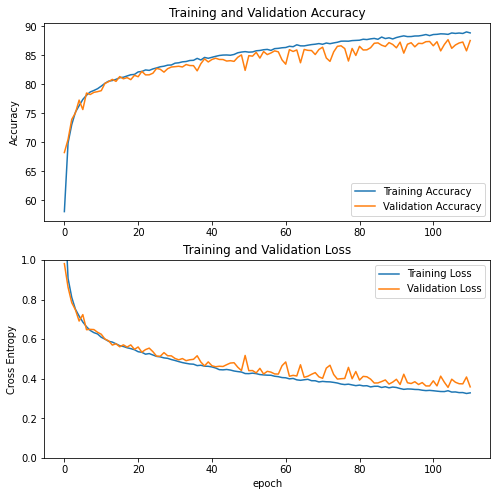

In [32]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, valid_set = random_split(data, [train_len, len(data) - train_len])

val_len = int(len(valid_set)*0.7)
validation_set, test_set = random_split(valid_set, [val_len, len(valid_set) - val_len])



# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val_loader)*batch_size)

test_loader = DataLoader(test_set, batch_size =batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a validation set is: 27392
The number of images in a test set is: 8224
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


**Accuracy calculated upon Validataion Data**

In [40]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Apple___healthy : 97 %
Accuracy of Apple_scab : 90 %
Accuracy of Black_rot : 89 %
Accuracy of Cedar_apple_rust : 94 %
Accuracy of Tomato_Target_spot : 91 %
Accuracy of Tomato__Late_blight : 81 %
Accuracy of Tomato__Septoria_leaf_spot : 74 %
Accuracy of Tomato__Spider_mites : 85 %
Accuracy of Tomato___Bacterial_spot : 96 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 97 %
Accuracy of Tomato__early_blight : 73 %
Accuracy of Tomato__healthy : 96 %


**Accuracy calculated upon Test Data**

In [43]:
#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

torch.cuda.BoolTensor
Accuracy of Apple___healthy : 95 %
Accuracy of Apple_scab : 89 %
Accuracy of Black_rot : 90 %
Accuracy of Cedar_apple_rust : 95 %
Accuracy of Tomato_Target_spot : 90 %
Accuracy of Tomato__Late_blight : 77 %
Accuracy of Tomato__Septoria_leaf_spot : 78 %
Accuracy of Tomato__Spider_mites : 85 %
Accuracy of Tomato___Bacterial_spot : 94 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 97 %
Accuracy of Tomato__early_blight : 71 %
Accuracy of Tomato__healthy : 94 %


In [38]:
avg = 0
for i in range(12):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/12
print('Average accuracy = ', avg)

Average accuracy =  88.95012671946004


**Confusion matrix using Validation Data**

[[1928   15    0    1    3    1    1    0   31    7    3    1]
 [  15 1791   23   42   25   40   10    3   10    7    9   14]
 [   4   74 1686    6   40   21   32   16    1    1   20   11]
 [   6   47    2 1809    0   27    8    0    4    8    5    0]
 [   1   11    4    0 2227    5   23  149    9    4   29   12]
 [   3   56    7   49   46 2009   41   51   12   27  141    9]
 [   7   68   31   17  166  120 1741   52   12   21  120   32]
 [   5    6    1    0  258   10   11 1959    3   21   28    4]
 [   9    3    0    8    2   12    0    0 2473   73    2    0]
 [   0    4    0    3    3    8    0    6   24 2557    1    0]
 [   7   48    5    1  176  213   54   53   12   31 1813    0]
 [   2    9    3    5   60    1    3   15    1    0    0 2251]]
[96.83576092 90.04524887 88.17991632 94.41544885 90.01616815 81.96654427
 72.93674068 84.95229835 95.77846631 98.11972371 75.13468711 95.78723404]


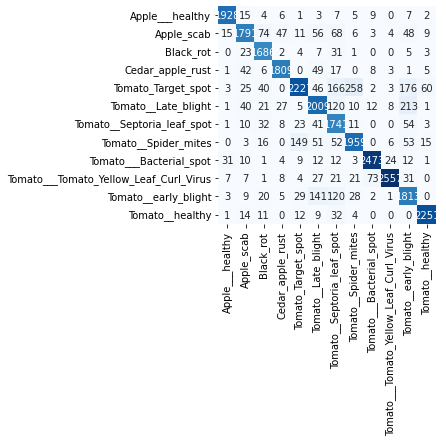

In [49]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)

**Confusion matrix plotted using Test Data**

[[1926   12    0    4    2    3    0    1   35    4    3    1]
 [  19 1780   25   38   26   45    8    2   13    4   11   18]
 [   5   65 1706    2   43   19   32    7    0    1   19   13]
 [   1   56    2 1803    0   28    8    0    3   10    3    2]
 [   2    9    1    0 2224    9   18  148    9    4   29   21]
 [   3   55    7   52   41 1993   54   53   10   25  147   11]
 [   5   64   24   22  159  119 1777   50    7   15  125   20]
 [   3   12    0    0  273   10   12 1930    2   29   30    5]
 [  17    1    0    4    5    5    0    0 2479   69    2    0]
 [   2    0    0    5    4   11    0    6   25 2551    2    0]
 [   8   44   10    2  183  209   56   54   14   29 1804    0]
 [   2   13    3    7   50    1    3   12    1    0    0 2258]]
[96.73530889 89.49220714 89.22594142 94.10229645 89.89490703 81.31374949
 74.44490993 83.69470945 96.01084431 97.8894858  74.76170742 96.08510638]


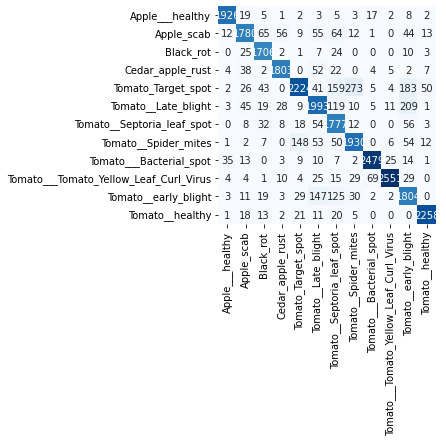

In [50]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)